In [29]:
root = "/home/jovyan/git/Collect&AnalyzeFinalProject"
import os
os.listdir(root)


['Project.ipynb',
 'ntbs.ipynb',
 'ba_q.parquet',
 'aryan.ipynb',
 '.devcontainer',
 'market_index.parquet',
 'luv_q.parquet',
 'DATA_NTBS',
 'financials.ipynb',
 'project ideas copy.md',
 'prices.parquet',
 'stocks.ipynb']

In [30]:
import subprocess, os
import polars as pl
import pandas as pd
from plotnine import *


INJURY_COUNT_THRESH = 1

pl.Config.set_tbl_rows(10000)  # or a large enough number for your table
pl.Config.set_tbl_width_chars(200)  # widen output if needed
pl.Config.set_tbl_cols(100)  # show all columns

root = root = "/home/jovyan/git/Collect&AnalyzeFinalProject"
mdb_path = os.path.join(root, "avall.mdb")

# # List all tables
# output = subprocess.check_output(["mdb-tables", "-1", mdb_path])
# tables = output.decode().strip().split("\n")

# for t in tables:
#     ofile_path = os.path.join(root, "ntbs", f"{t}.csv")
#     with open(ofile_path, "w") as f:
#         subprocess.run(["mdb-export", mdb_path, t], stdout=f, check=True)

In [31]:
events = pl.read_csv(
    os.path.join(root, "DATA_NTBS/events.csv"),
    null_values=["null", "Null", "None", "none", "NA", "na"],
    ignore_errors=True,
)
aircrafts = pl.read_csv(
    os.path.join(root, "DATA_NTBS/aircraft.csv"),
    null_values=["null", "Null", "None", "none", "NA", "na"],
    ignore_errors=True,
)

# Robust datetime parsing for ev_date
parsed1 = pl.col("ev_date").str.strptime(pl.Datetime, "%m/%d/%y %H:%M:%S", strict=False)
parsed2 = pl.col("ev_date").str.strptime(pl.Datetime, "%m/%d/%Y %H:%M:%S", strict=False)
events = (
    events.with_columns(
        inj_all_tot=pl.col("inj_tot_f") + pl.col("inj_tot_m") + pl.col("inj_tot_s")
    )
    .filter(pl.col("inj_all_tot") > INJURY_COUNT_THRESH)
    .with_columns(ev_date=pl.coalesce([parsed1, parsed2]))
)


cols = (
    "ev_id, ev_type, ev_time, ev_city, ev_country, ev_year, inj_tot_f,	inj_tot_m,	inj_tot_s, inj_all_tot, ev_date".replace(
        " ", ""
    )
    .replace("\t", "")
    .split(",")
)
events = events.select(pl.col(cols))


cols = [
    "ev_id",
    "Aircraft_Key",
    "acft_make",
    "acft_model",
    "damage",
    "oper_name",
]
aircrafts = aircrafts.select(pl.col(cols))
aircrafts
public_makes = [
    "BOEING",
    "AIRBUS",
    "AIRBUS INDUSTRIE",
    "MCDONNELL DOUGLAS",  # Boeing now
    "BOMBARDIER",  # same as canadaair
    "CANADAIR",
    "BRITISH AEROSPACE",
]
aircrafts = aircrafts.filter(pl.col("acft_make").is_in(public_makes))
aircrafts
events = aircrafts.join(events, on="ev_id", how="inner")

In [32]:
events.write_parquet(os.path.join(root, "DATA_NTBS/processed.parquet"))

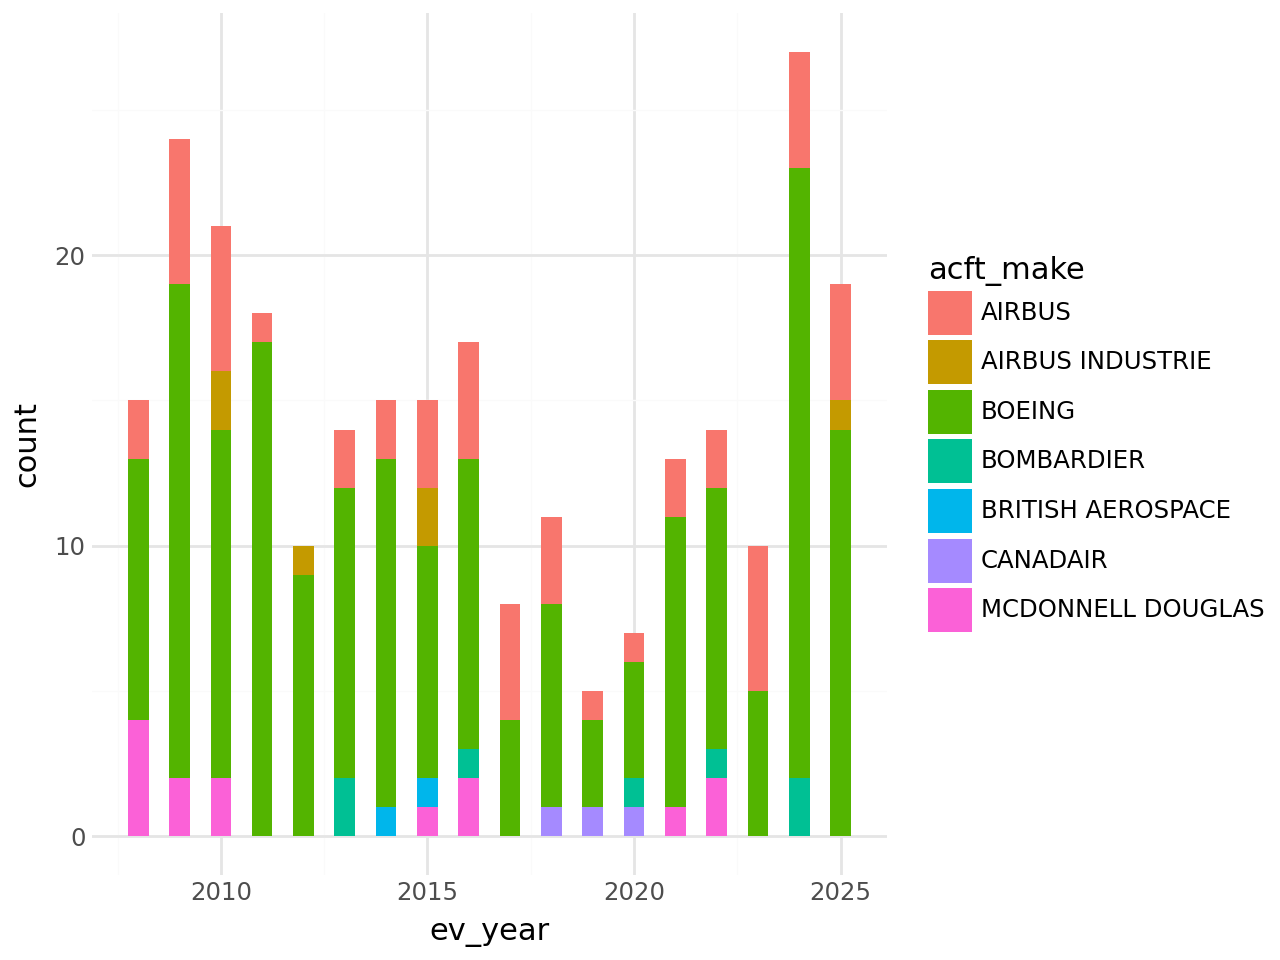

In [33]:
(
    ggplot(events, aes(x="ev_year", fill="acft_make"))
    + geom_histogram(bins=35)
    + theme_minimal()
)


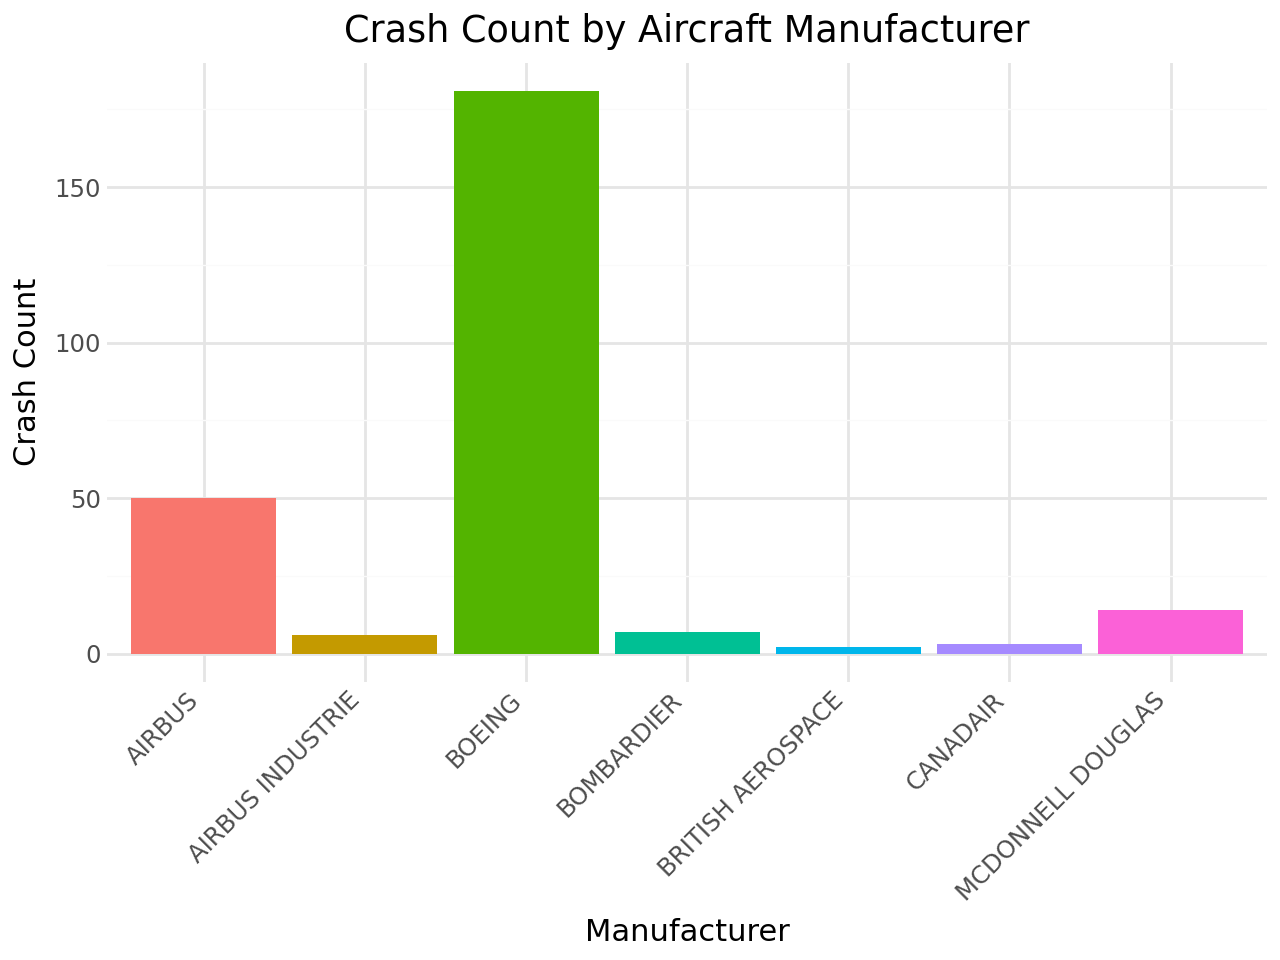

In [34]:
df_counts = events.group_by("acft_make").agg(count=pl.len())
# Plot
(
    ggplot(df_counts, aes(x="acft_make", y="count", fill="acft_make"))
    + geom_col(show_legend=False)
    + labs(
        title="Crash Count by Aircraft Manufacturer", x="Manufacturer", y="Crash Count"
    )
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=45, ha="right"))
)

/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:356: PlotnineWarning: position_stack : Removed 1 rows containing missing values.


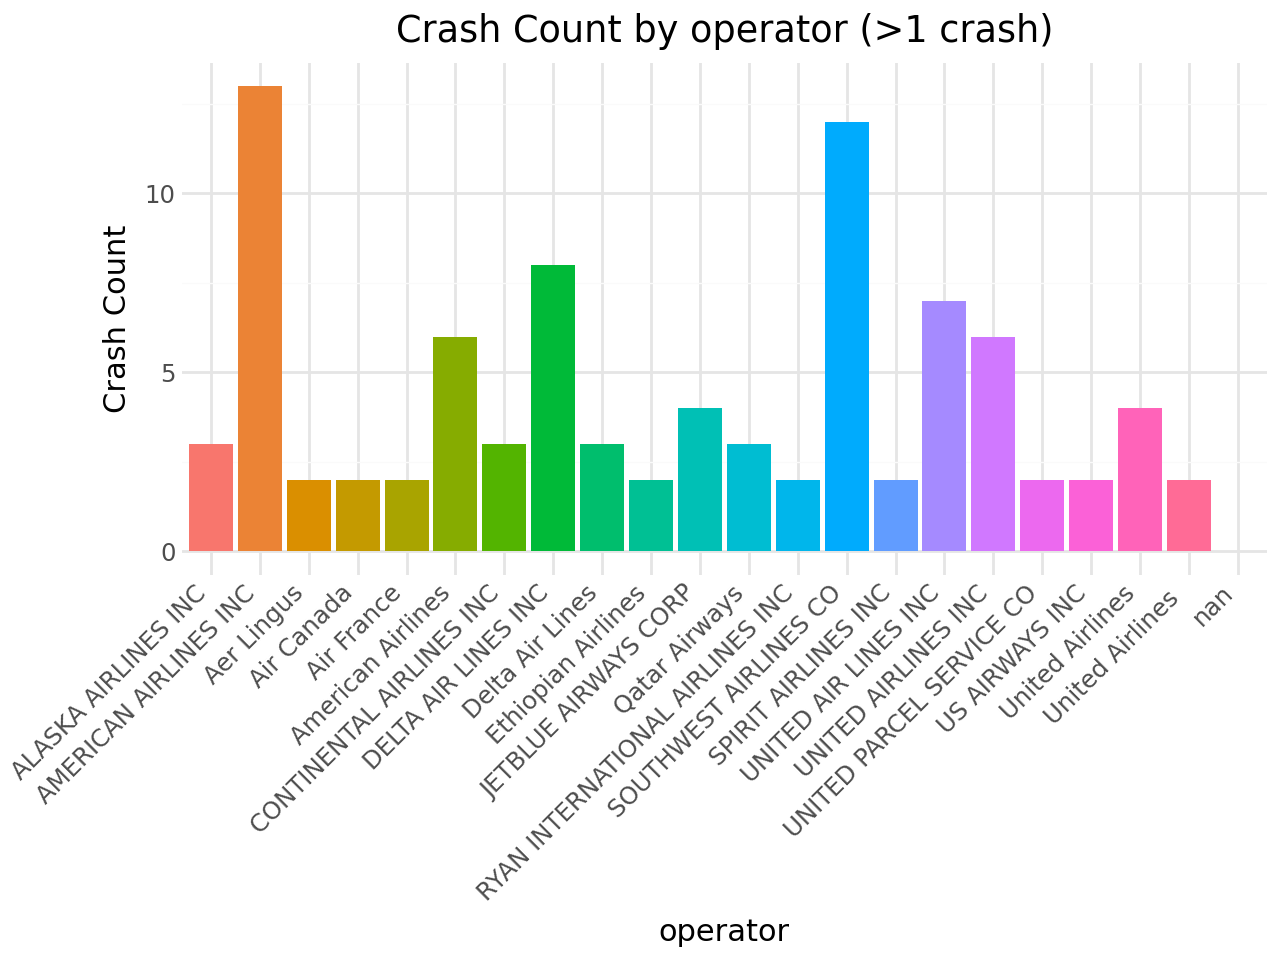

In [35]:
df_counts = events.group_by("oper_name").agg(count=pl.len()).filter(pl.col("count") > 1)
# Plot
(
    ggplot(df_counts, aes(x="oper_name", y="count", fill="oper_name"))
    + geom_col(show_legend=False)
    + labs(title="Crash Count by operator (>1 crash)", x="operator", y="Crash Count")
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=45, ha="right"))
)

# events.group_by("oper_name").agg(count=pl.len())

In [36]:
events.select(
    pl.col(["oper_name", "acft_make", "inj_all_tot", "ev_year", "ev_date"])
).sort("inj_all_tot", descending=True)

oper_name,acft_make,inj_all_tot,ev_year,ev_date
str,str,i64,i64,datetime[μs]
"""MALAYSIAN AIRLINES SYSTEM BERH…","""BOEING""",298,2014,2014-07-17 00:00:00
"""Air France""","""AIRBUS""",228,2009,2009-06-01 00:00:00
null,"""AIRBUS""",224,2015,2015-10-31 00:00:00
null,"""BOEING""",191,2018,2018-10-29 00:00:00
"""Asiana Airlines""","""BOEING""",190,2013,2013-07-06 00:00:00
"""Pegasus Airlines ""","""BOEING""",183,2020,2020-02-05 00:00:00
"""Ukraine International Airlines""","""BOEING""",176,2020,2020-01-08 00:00:00
"""Jeju Air""","""BOEING""",175,2024,2024-12-29 00:00:00
"""Air India Charters""","""BOEING""",165,2010,2010-05-22 00:00:00


In [38]:
narratives = pl.read_csv(
    os.path.join(root, "DATA_NTBS/narratives.csv"),
    null_values=["null", "Null", "None", "none", "NA", "na"],
    ignore_errors=True,
)
narratives.head(3)

ev_id,Aircraft_Key,narr_accp,narr_accf,narr_cause,narr_inc,lchg_date,lchg_userid
str,i64,str,str,str,str,str,str
"""20080211X00175""",1,"""import""",null,null,null,"""09/23/25 18:50:18""","""dobn"""
"""20080107X00026""",1,"""On January 1, 2008, about 1430…","""The pilots were attending a fl…","""The departing pilot's inadequa…",null,"""09/25/20 18:05:31""",null
"""20080107X00026""",2,"""On January 1, 2008, about 1430…","""The pilots were attending a fl…","""The departing pilot's inadequa…",null,"""09/25/20 18:05:31""",null


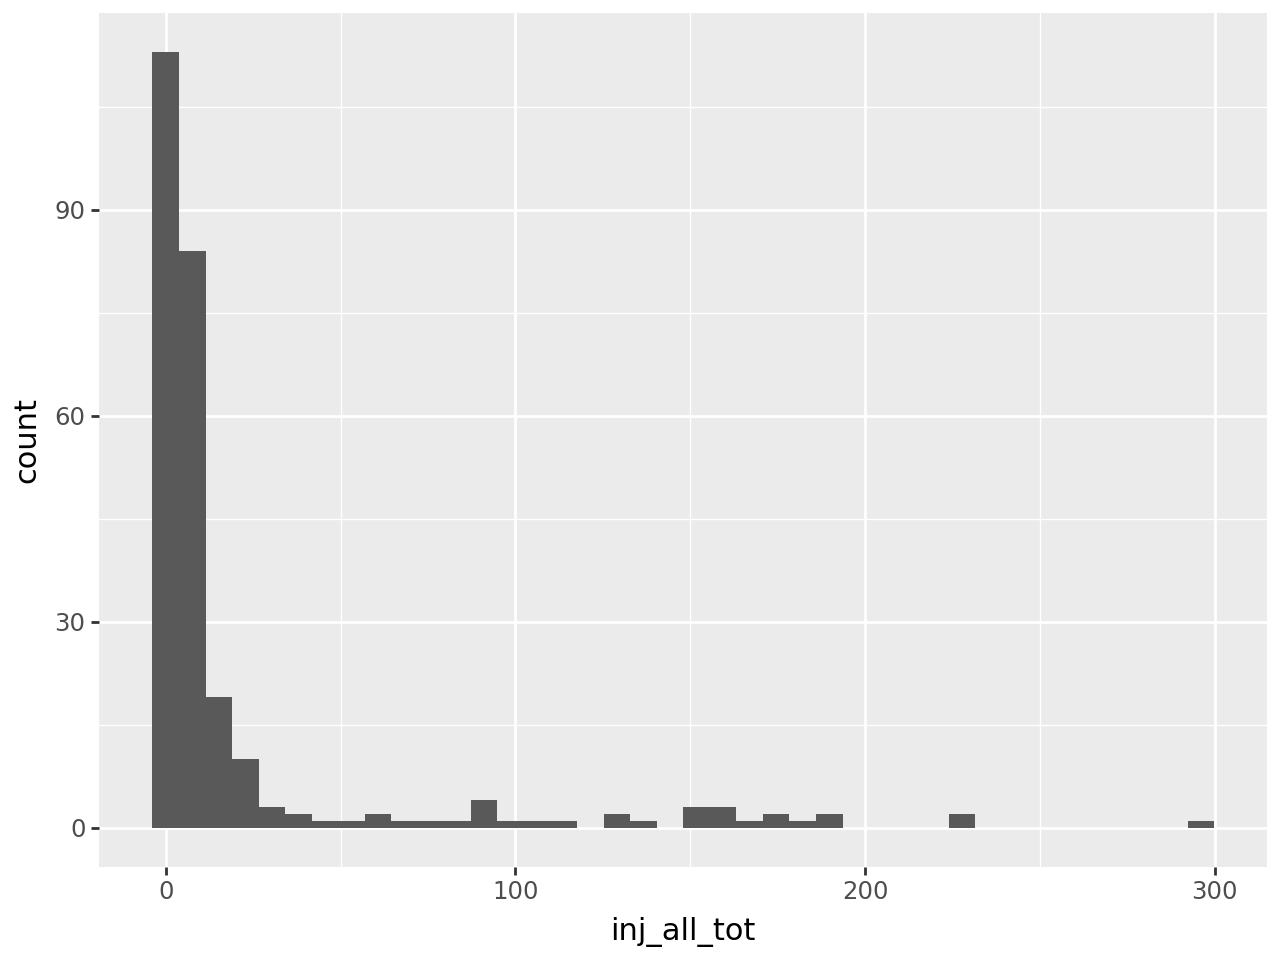

In [ ]:
ggplot(events, aes(x="inj_all_tot")) + geom_histogram(bins=40)

In [ ]:
events.select(
    [
        pl.col("inj_all_tot").quantile(0.5).alias("p50"),
        pl.col("inj_all_tot").quantile(0.75).alias("p75"),
        pl.col("inj_all_tot").quantile(0.9).alias("p90"),
        # pl.col("inj_all_tot").quantile(0.99).alias("p99"),
    ]
)


p50,p75,p90
f64,f64,f64
4.0,12.0,77.0


- Low severity
1–10 injuries
Covers everything <= median and about half of your <= 75th percentile

- Medium severity
11–77 injuries
Straddles the region between your 75th percentile (12) and your 90th percentile (77) “True accidents but not catastrophic”


- High severity
j > 77 injuries
Captures top ~10–15%
Includes basically everything ≥ 75–100 injuries
These are the events that actually move markets